---
# Topological Cluster Statistics (TCS)

---

## Notebook 19: ribbon simulations


---

This notebook contains scripts that perform the presented simulations on a hypothetical gray matter ribbon.



---

### Packages and basic functions


---

Loading required packages


In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.sparse as sparse
from sklearn import metrics
from distinctipy import distinctipy
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap
from scipy import signal, spatial
import sklearn.preprocessing



---

Basic functions


In [2]:
def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)

    
def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))


---

### Generating the random ribbon


In [3]:
# fix random seed for reproducibility
random_seed = 1
np.random.seed(random_seed)

nx = 80
ny = 80
grid_shape = (nx, ny)

x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
grid_x, grid_y = np.meshgrid(x, y)

distance_to_grid_center = np.power((np.power(grid_x, 2) + np.power(grid_y, 2)), 0.5)
angle_from_center = np.arctan2(grid_y, grid_x)

ribbon_grid = ((0.75<distance_to_grid_center) & (distance_to_grid_center<0.95))

# let's create a parcellation around the grid
n_sections = 11
shift_operator = -np.pi / 2

section_labels = np.multiply(ribbon_grid, 1 + (np.floor((0.5 + ((angle_from_center + shift_operator) / (2*np.pi))) * n_sections) % n_sections))

label_colors = ListedColormap([(0.9,0.9,0.9)] + distinctipy.get_colors(n_sections, pastel_factor=0.1, colorblind_type='Deuteranomaly', rng=3))

label_center_x = [grid_x[section_labels == (x+1)].mean() for x in range(n_sections)]
label_center_y = [-grid_y[section_labels == (x+1)].mean() for x in range(n_sections)]

# predefined network over labels
adj = [(0, 1), (1, 2), (1,9), (2,5), (2,8), (3,4), (5,8), (6,7), (8,9), (9,10)]


# noise2d = np.random.rand(100,100)
noise2d = np.random.normal(0, 2., size=grid_shape)

# get gaussian smoothing kernel (noise with spatial autocorrelation)
# Initializing value of x-axis and y-axis
# in the range -1 to 1
gx, gy = np.meshgrid(np.linspace(-1,1,7), np.linspace(-1,1,7))
dst = np.sqrt(gx*gx+gy*gy)
 
# Initializing sigma and mu
sigma = 0.5
mu = 0.000
 
# Calculating Gaussian array
gauss = np.exp(-( (dst-mu)**2 / ( 2.0 * sigma**2 ) ) )

gauss_noise2d = signal.convolve2d(noise2d, gauss, mode='same')

# True effect creation
cx_1 = label_center_x[1]
cy_1 = -label_center_y[1]
r_1 = 0.18
eff_1 = (np.power((np.power((grid_x - cx_1), 2) + np.power((grid_y - cy_1), 2)), 0.5) < r_1)

cx_2 = label_center_x[2]
cy_2 = -label_center_y[2]
r_2 = 0.05
eff_2 = (np.power((np.power((grid_x - cx_2), 2) + np.power((grid_y - cy_2), 2)), 0.5) < r_2)

cx_3 = label_center_x[8]
cy_3 = -label_center_y[8]
r_3 = 0.15
eff_3 = (np.power((np.power((grid_x - cx_3), 2) + np.power((grid_y - cy_3), 2)), 0.5) < r_3)

effect = np.multiply(ribbon_grid, (eff_1 | eff_2 | eff_3))


# smoothed effect
gx, gy = np.meshgrid(np.linspace(-1,1,5), np.linspace(-1,1,5))
dst = np.sqrt(gx*gx+gy*gy)
sigma = 0.5
mu = 0.000
gauss = np.exp(-( (dst-mu)**2 / ( 2.0 * sigma**2 ) ) )
gauss_effect = signal.convolve2d(effect, gauss, mode='same')

masked_gauss_noise2d = np.multiply(gauss_noise2d, (1 - ((gauss_effect - gauss_effect.min())/gauss_effect.max())))

# mix noise and effect to get a noised signal
a = 0.1
true_signal = gauss_effect + (a * masked_gauss_noise2d) + (a * gauss_noise2d)


In [4]:
# high-resolution node definitions
hrn = nx*ny
hr_nodes = np.arange(hrn)
hr_structure = hr_nodes.reshape(nx, ny)
hr_structure

hr_spatial_connectivity = sparse.dok_matrix((hrn, hrn))

node_to_xy = {}
node_coord = np.zeros((hrn, 2))

for ix in range(nx):
    for iy in range(ny):
        node_to_xy[hr_structure[ix, iy]] = (ix, iy)
        node_coord[hr_structure[ix, iy]] = (grid_x[ix, iy], grid_y[ix, iy])
        if ribbon_grid[ix, iy]:
            if ix>0:
                if ribbon_grid[ix-1, iy]:
                    hr_spatial_connectivity[hr_structure[ix, iy], hr_structure[ix-1, iy]] = 1
                    hr_spatial_connectivity[hr_structure[ix-1, iy], hr_structure[ix, iy]] = 1
            if iy>0:
                if ribbon_grid[ix, iy-1]:
                    hr_spatial_connectivity[hr_structure[ix, iy], hr_structure[ix, iy-1]] = 1
                    hr_spatial_connectivity[hr_structure[ix, iy-1], hr_structure[ix, iy]] = 1

hr_spatial_connectivity = hr_spatial_connectivity.tocoo()


In [5]:
# create a spatial smoothing kernel
kdtree = spatial.cKDTree(node_coord)

max_distance = 0.07

local_distance = kdtree.sparse_distance_matrix(kdtree, max_distance)

sigma = fwhm2sigma(0.1)
smothing_kernel = -(local_distance.power(2) / (2 * (sigma ** 2)))
smothing_kernel += sparse.eye(smothing_kernel.shape[0], dtype=smothing_kernel.dtype).tocsr()
sklearn.preprocessing.normalize(smothing_kernel, norm='l1')


<6400x6400 sparse matrix of type '<class 'numpy.float64'>'
	with 130900 stored elements in Compressed Sparse Row format>

In [6]:
# create smoothed topology
hr_topological_connectivity = sparse.dok_matrix((hrn, hrn))

for i, j in adj:
    center_i = label_center_x[i], -label_center_y[i]
    center_j = label_center_x[j], -label_center_y[j]
    
    node_i = kdtree.query(center_i)[1]
    node_j = kdtree.query(center_j)[1]
    
    hr_topological_connectivity[node_i, node_j] = 1

hr_topological_connectivity = hr_topological_connectivity.tocsr()

hr_topological_connectivity = smothing_kernel.T.dot(hr_topological_connectivity.dot(smothing_kernel))

hr_topological_connectivity = hr_topological_connectivity.tocoo()

hr_combined_connectivity = ((hr_spatial_connectivity + hr_topological_connectivity)>0).astype(float)


In [7]:
def draw_line(x1, y1, x2, y2):
    a = np.linspace(0,1,2)
    lx = (a * x2) + ((1-a) * x1)
    ly = (a * y2) + ((1-a) * y1)
    
    return lx, ly

def draw_curve(x1, y1, x2, y2):
    a = np.linspace(0,1)
    d = 1. + np.sqrt((x1 - x2)**2 + (y1 - y2)**2)/2
    lx = (a**d * x2) + ((1-a)**d * x1)
    ly = (a**d * y2) + ((1-a)**d * y1)
    
    return lx, ly


In [8]:
def get_all_cluster_extents(cortical_effect, effect_threshold, cluster_connectivity, size_threshold=1, magnitude=True):
    # first mask regions with weak effects
    if magnitude:
        suprathreshold_mask = sparse.diags((np.abs(cortical_effect) > effect_threshold).astype(float), 0)
    else:
        suprathreshold_mask = sparse.diags(((cortical_effect) > effect_threshold).astype(float), 0)

    # update connectivity to keep masked edges only
    thresholded_connectivity = (suprathreshold_mask.dot(cluster_connectivity.dot(suprathreshold_mask))).tocsr()

    # compute all connected components
    n_components, labels = sparse.csgraph.connected_components(csgraph=thresholded_connectivity, directed=False, return_labels=True)

    # count the labels and report clusters
    unique, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique, counts))

    label_replace = {x:(x if label_counts[x]>size_threshold else -1) for x in label_counts}

    cluster_labels = [label_replace[x] for x in labels]
    cluster_size = {x:label_counts[x] for x in label_counts if label_counts[x]>size_threshold}

    final_label_replace ={x:i for (i,x) in enumerate(np.unique(cluster_labels))}
    final_cluster_size = {final_label_replace[x]:cluster_size[x] for x in cluster_size}
    final_cluster_labels = [final_label_replace[x] for x in cluster_labels]
    
    return (final_cluster_size, final_cluster_labels)


In [9]:
(spatial_cluster_size, spatial_cluster_labels) = get_all_cluster_extents(
    np.multiply(ribbon_grid, true_signal).reshape(-1), 2.0, hr_spatial_connectivity, magnitude=False,
)

spatial_cluster_label_grid = np.array(spatial_cluster_labels).reshape(nx, ny)
spatial_cluster_size_grid = np.array([spatial_cluster_size.get(x, 0) for x in spatial_cluster_labels]).reshape(nx, ny)

spatial_suprathreshold_mask = sparse.diags((spatial_cluster_size_grid.reshape(-1)>70).astype(float), 0)
remaining_spatial_connectivity = (spatial_suprathreshold_mask.T.dot(hr_spatial_connectivity.tocsr().dot(spatial_suprathreshold_mask))).tocoo()

(topological_cluster_size, topological_cluster_labels) = get_all_cluster_extents(
    np.multiply(ribbon_grid, true_signal).reshape(-1), 2.0, hr_combined_connectivity, magnitude=False,
)

topological_cluster_label_grid = np.array(topological_cluster_labels).reshape(nx, ny)
topological_cluster_size_grid = np.array([topological_cluster_size.get(x, 0) for x in topological_cluster_labels]).reshape(nx, ny)

topological_suprathreshold_mask = sparse.diags((topological_cluster_size_grid.reshape(-1)>70).astype(float), 0)
remaining_topological_connectivity = (topological_suprathreshold_mask.T.dot(hr_topological_connectivity.tocsr().dot(topological_suprathreshold_mask))).tocoo()


Simulated cortical ribbon


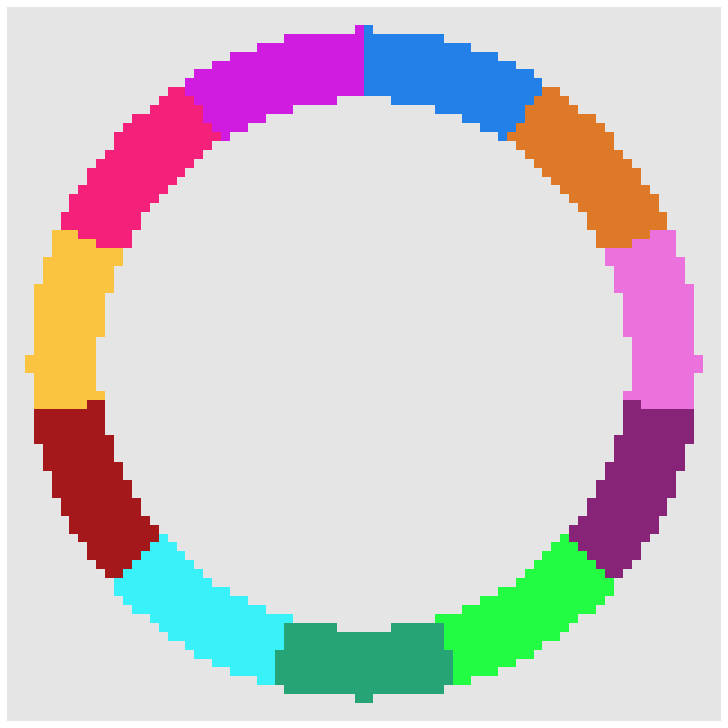

In [10]:
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(section_labels, cmap=label_colors, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
ax.axis('off')

print('Simulated cortical ribbon')


Spaial structure


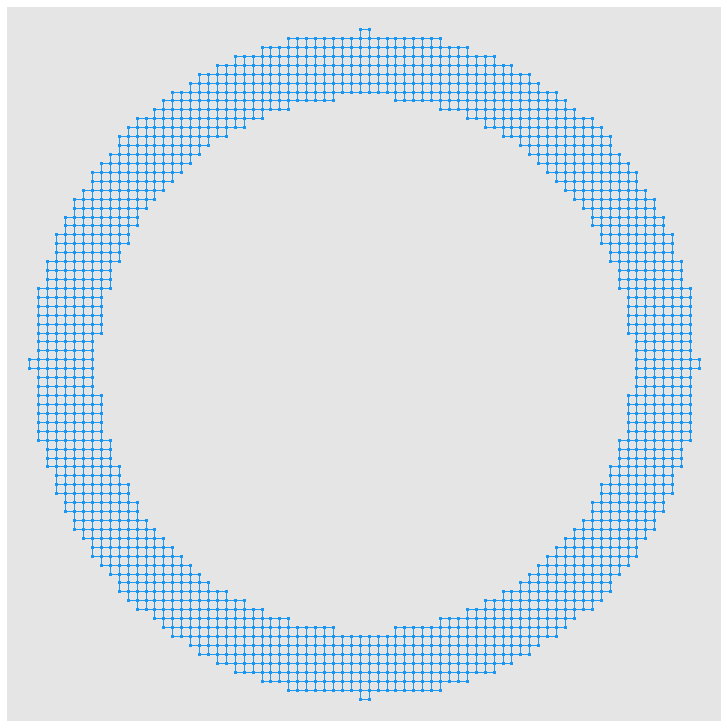

In [11]:
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(section_labels*0, cmap=label_colors, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
for (v1, v2) in zip(hr_spatial_connectivity.row, hr_spatial_connectivity.col):
    lx, ly = draw_line(grid_x[node_to_xy[v1]], grid_y[node_to_xy[v1]], grid_x[node_to_xy[v2]], grid_y[node_to_xy[v2]],)
    ax.plot(lx, ly, color=(0.1, 0.587, 0.95), linewidth=0.8, marker='o', markersize=2)
ax.axis('off')

print('Spaial structure')


Anatomical wiring


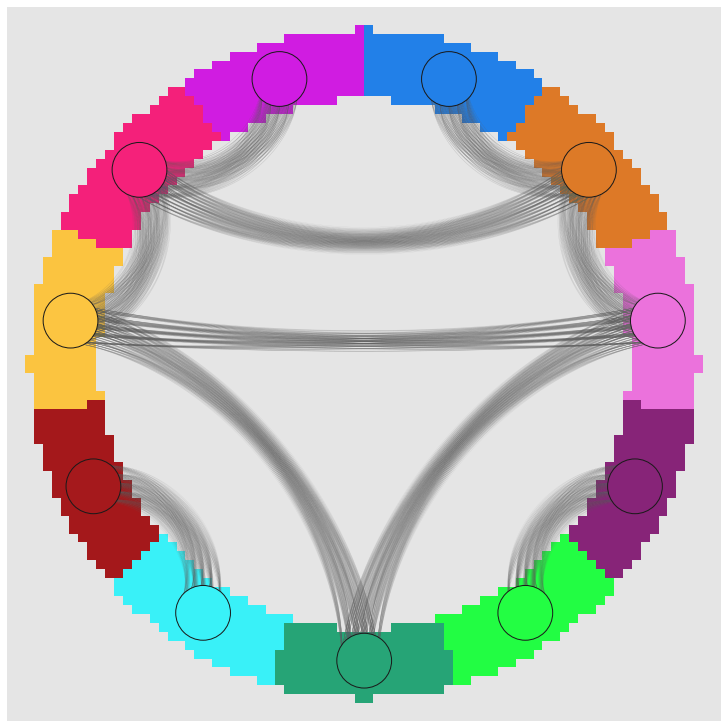

In [12]:
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(section_labels, cmap=label_colors, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
for (v1, v2) in zip(hr_topological_connectivity.row, hr_topological_connectivity.col):
    lx, ly = draw_curve(grid_x[node_to_xy[v1]], -grid_y[node_to_xy[v1]], grid_x[node_to_xy[v2]], -grid_y[node_to_xy[v2]],)
    ax.plot(lx, ly, color=(0.4,0.4,0.4), linewidth=0.2, alpha=0.2)
ax.scatter(
    (label_center_x),
    (label_center_y),
    c=[x for x in range(n_sections)],
    cmap=ListedColormap(distinctipy.get_colors(n_sections, pastel_factor=0.1, colorblind_type='Deuteranomaly', rng=3)),
    s=3000, zorder=20, edgecolors=(0.1,0.1,0.1),
)
ax.axis('off')

print('Anatomical wiring')


Anatomical wiring


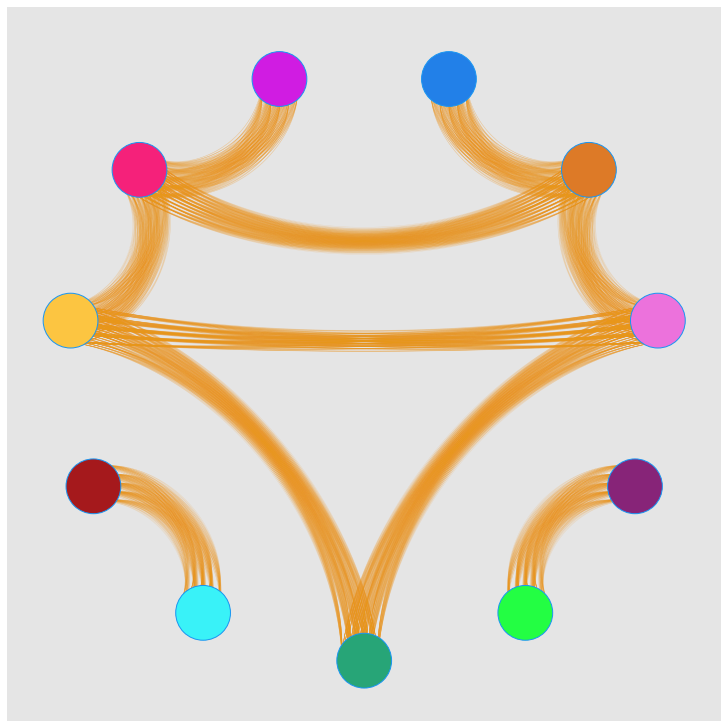

In [13]:
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(0*section_labels, cmap=label_colors, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
for (v1, v2) in zip(hr_topological_connectivity.row, hr_topological_connectivity.col):
    lx, ly = draw_curve(grid_x[node_to_xy[v1]], -grid_y[node_to_xy[v1]], grid_x[node_to_xy[v2]], -grid_y[node_to_xy[v2]],)
    ax.plot(lx, ly, color=(0.95, 0.587, 0.1), linewidth=0.4, alpha=0.2)
ax.scatter(
    (label_center_x),
    (label_center_y),
    c=[x for x in range(n_sections)],
    cmap=ListedColormap(distinctipy.get_colors(n_sections, pastel_factor=0.1, colorblind_type='Deuteranomaly', rng=3)),
    s=3000, zorder=10, edgecolors=(0.1,0.587,0.95), alpha=1.,
)
ax.axis('off')

print('Anatomical wiring')


Ground truth


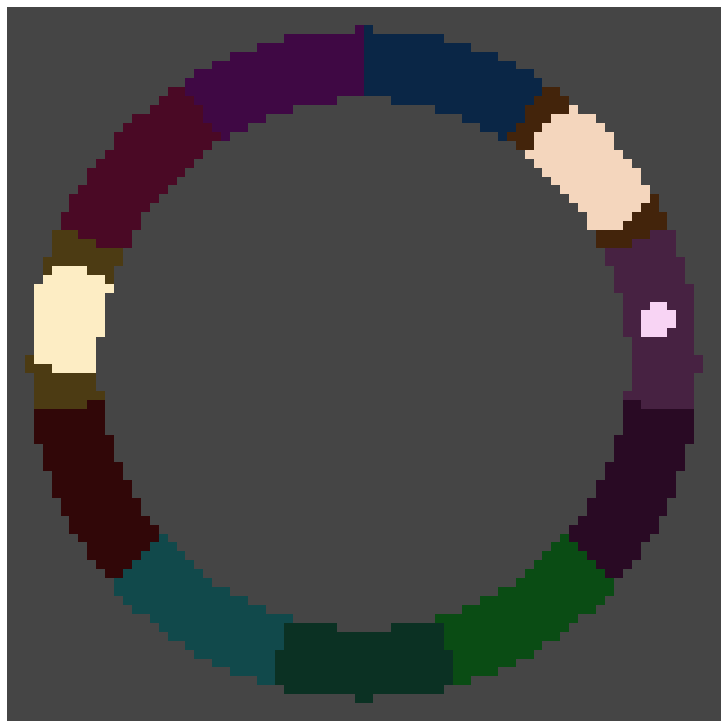

In [14]:
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(section_labels, cmap=label_colors, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
ax.imshow(effect, cmap=plt.cm.gist_gray, alpha=0.7, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
ax.axis('off')

print('Ground truth')


Statistical map


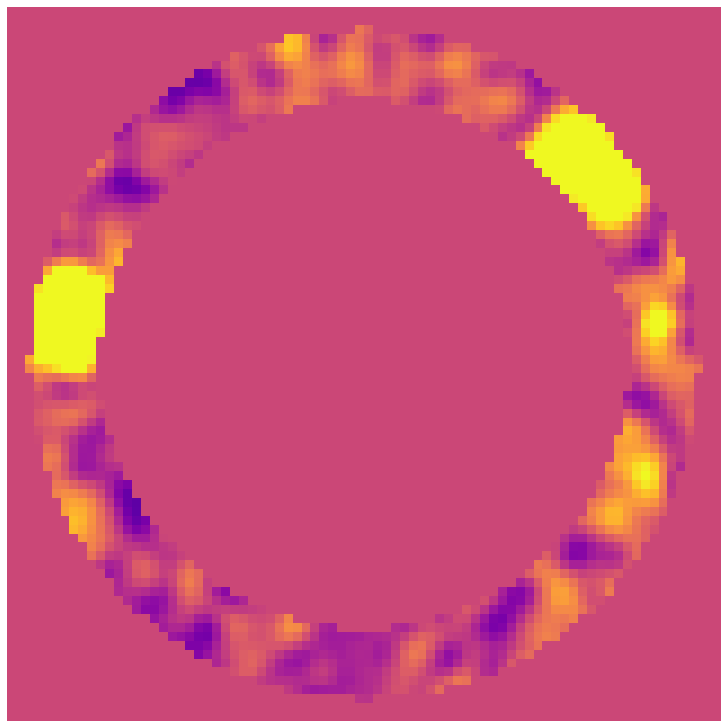

In [15]:
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(np.multiply(ribbon_grid, true_signal), cmap=plt.cm.plasma, alpha=1., extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)], vmin=-4, vmax=4,)
ax.axis('off')

print('Statistical map')


Spatial statistic


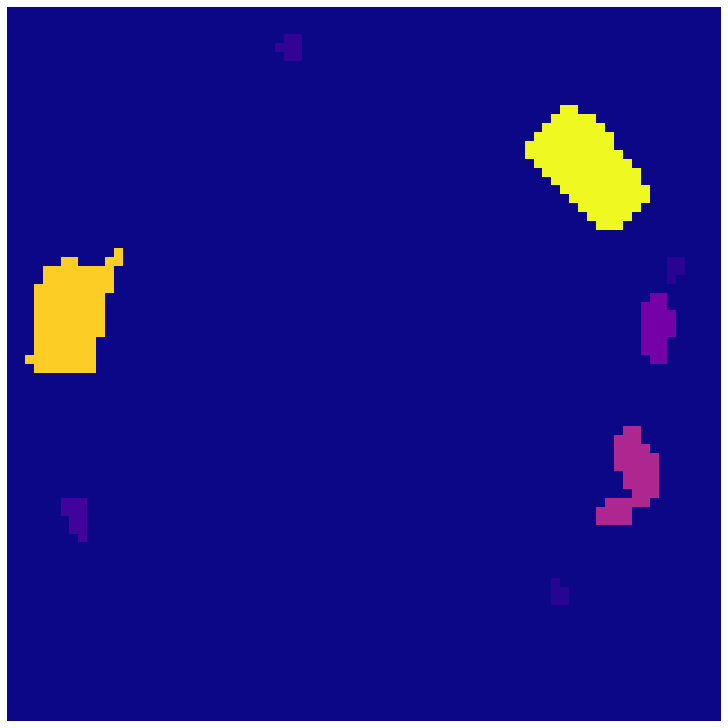

In [16]:
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(section_labels, cmap=label_colors, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
ax.imshow(spatial_cluster_size_grid, cmap=plt.cm.plasma, alpha=1., extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
ax.axis('off')

print('Spatial statistic')


Spatial significant clusters


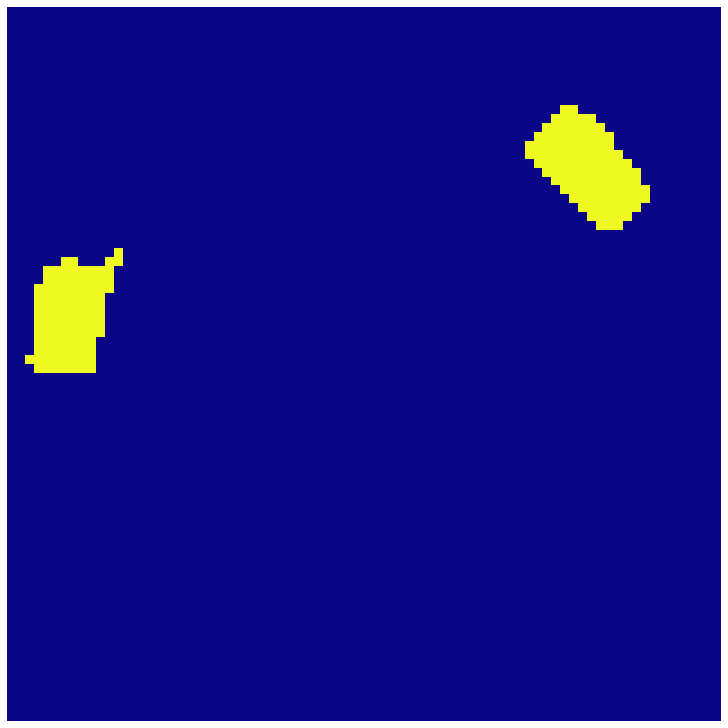

In [17]:
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(section_labels, cmap=label_colors, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
ax.imshow(spatial_cluster_size_grid>70, cmap=plt.cm.plasma, alpha=1., extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
ax.axis('off')

print('Spatial significant clusters')


Topological cluster statistic


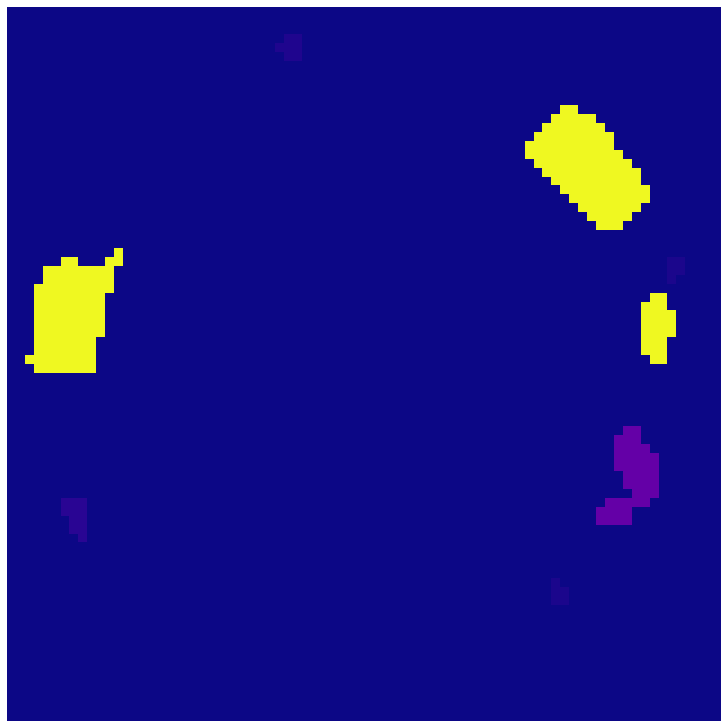

In [18]:
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(section_labels, cmap=label_colors, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
ax.imshow(topological_cluster_size_grid, cmap=plt.cm.plasma, alpha=1, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
ax.axis('off')

print('Topological cluster statistic')


TCS survived clusters


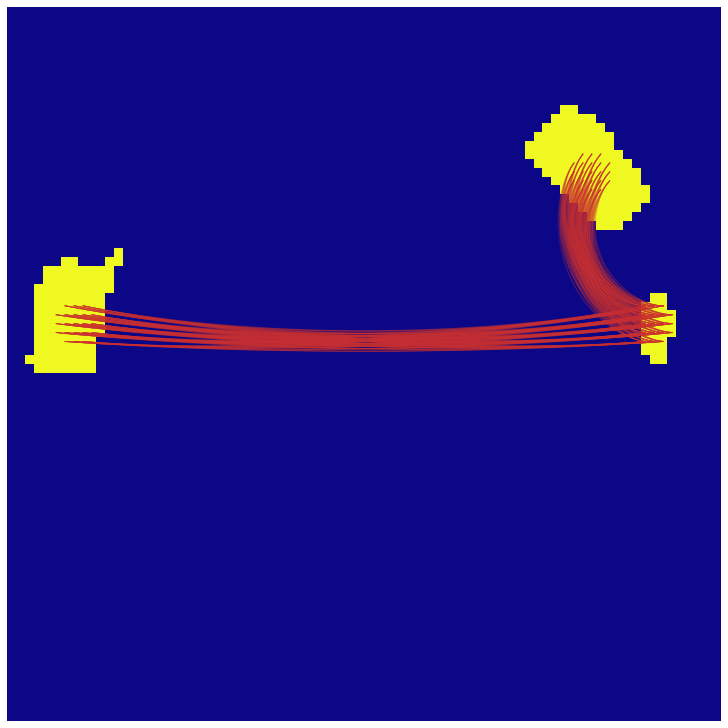

In [19]:
fig = plt.figure(figsize=(10, 10),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(section_labels, cmap=label_colors, extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
ax.imshow(topological_cluster_size_grid>70, cmap=plt.cm.plasma, alpha=1., extent=[-((1+nx)/nx),((1+nx)/nx),-((1+ny)/ny),((1+ny)/ny)])
for (v1, v2) in zip(remaining_topological_connectivity.row, remaining_topological_connectivity.col):
    lx, ly = draw_curve(grid_x[node_to_xy[v1]], -grid_y[node_to_xy[v1]], grid_x[node_to_xy[v2]], -grid_y[node_to_xy[v2]],)
    ax.plot(lx, ly, color=(0.8,0.2,0.2), linewidth=0.8, alpha=0.2)
ax.axis('off')

print('TCS survived clusters')
